In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import dlib
from cv2 import WINDOW_NORMAL
import pickle
import numpy as np
import math


In [2]:
detector = dlib.get_frontal_face_detector() # Face detector
# Landmark identifyier. Set the filename to whatever you named the downloaded filename
model = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Testing with your webcam

In [6]:
def get_landmarks_with_point(image, frame):
    detections = detector(image, 1)
    # For all detected face instances individually
    for k,d in enumerate(detections):
        # Get facial landmarks with prediction model
        shape = model(image, d)
        xpoint = []
        ypoint = []
        for i in range(0, 68):
            if (i == 27) | (i == 30):
                # For each point, draw a red circle with thickness2 on the original frame
                cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0, 0, 255), thickness=2)
            xpoint.append(float(shape.part(i).x))
            ypoint.append(float(shape.part(i).y))

        # Center points of both axis
        xcenter = np.mean(xpoint)
        ycenter = np.mean(ypoint)
        
        # Calculate distance between particular points and center point
        xdistcent = [(x-xcenter) for x in xpoint]
        ydistcent = [(y-ycenter) for y in ypoint]

        # Prevent divided by 0 value
        if xpoint[11] == xpoint[14]:
            angle_nose = 0
        else:
            # Point 14 is the tip of the nose, point 11 is the top of the nose brigde
            angle_nose = int(math.atan((ypoint[11]-ypoint[14])/(xpoint[11]-xpoint[14]))*180/math.pi)

        # Get offset by finding how the nose brigde should be rotated to become perpendicular to the horizontal plane
        if angle_nose < 0:
            angle_nose += 90
        else:
            angle_nose -= 90

        landmarks = []
        for cx, cy, x, y in zip(xdistcent, ydistcent, xpoint, ypoint):
            # Add the coordinates relative to the centre of gravity
            landmarks.append(cx)
            landmarks.append(cy)

            # Get the euclidean distance between each point and the centre point (the vector length)
            meanar = np.asarray((ycenter,xcenter))
            centpar = np.asarray((y,x))
            dist = np.linalg.norm(centpar-meanar)

            # Get the angle the vector describes relative to the image, corrected for the offset that the nose-bridge
            # has when the face is not perfectly horizontal
            if x == xcenter:
                angle_relative = 0
            else:
                angle_relative = (math.atan(float(y-ycenter)/(x-xcenter))*180/math.pi) - angle_nose

            landmarks.append(dist)
            landmarks.append(angle_relative)

    if len(detections) < 1:
        # If no face is detected set the data to value "error" to catch detection errors
        landmarks = "error"
    return landmarks

In [7]:
def show_webcam_and_run(model, emotions, window_size=None, window_name='webcam', update_time=10):
    cv2.namedWindow(window_name, WINDOW_NORMAL)
    if window_size:
        width, height = window_size
        cv2.resizeWindow(window_name, width, height)

    # Set up some required objects
    vc = cv2.VideoCapture(0)    # Webcam objects

    if vc.isOpened():
        ret, frame = vc.read()
    else:
        print("webcam not found")
        return

    while ret:
        training_data = []
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_image = clahe.apply(gray)

        # Get Point and Landmarks
        landmarks_vectorised = get_landmarks_with_point(clahe_image, frame)

        if landmarks_vectorised == "error":
            pass
        else:
            # Predict emotion
            training_data.append(landmarks_vectorised)
            npar_pd = np.array(training_data)
            prediction_emo = model.predict(npar_pd)
            if cv2.__version__ != '3.1.0':
                prediction_emo = prediction_emo[0]
            print(prediction_emo)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, prediction_emo, (50, 50),font, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow(window_name, frame)  # Display the frame
        ret, frame = vc.read()

        if cv2.waitKey(1) & 0xFF == ord('q'):   # Exit program when user press 'q'
            break

In [8]:
if __name__ == '__main__':
    emotions = ["angry", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]
    model_file = os.path.join('models', 'model1.pkl')
    pkl_file = open(model_file, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()

    window_name = 'WEBCAM (press q to exit)'
    show_webcam_and_run(data, emotions, window_size=(800, 600), window_name=window_name, update_time=8)

contempt
contempt
anger
anger
anger
anger
anger
anger
anger
contempt
contempt
happy
happy
happy
happy
happy
happy
happy
happy
happy
happy
happy
happy
contempt
anger
anger
anger
anger
anger
anger
contempt
contempt
contempt
fear
fear
fear
fear
fear
fear
fear
fear
contempt
happy
happy
happy
happy
happy
happy
happy
happy
happy
contempt


# Testing with images saved on your computer

In [3]:
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askopenfilename

# Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
# filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
# print(filename)

In [4]:
def get_landmarks(image):
    detections = detector(image, 1)
    # For all detected face instances individually
    for k, d in enumerate(detections):
        shape = model(image, d)# Get facial landmarks with prediction model
        xpoint = []
        ypoint = []
        for i in range(0, 68):
            xpoint.append(float(shape.part(i).x))
            ypoint.append(float(shape.part(i).y))

        # Center points of both axis
        xcenter = np.mean(xpoint)
        ycenter = np.mean(ypoint)
        # Calculate distance between particular points and center point
        xdistcent = [(x-xcenter) for x in xpoint]
        ydistcent = [(y-ycenter) for y in ypoint]

        # Prevent divided by 0 value
        if xpoint[11] == xpoint[14]:
            angle_nose = 0
        else:
            # Point 14 is the tip of the nose, point 11 is the top of the nose brigde
            angle_nose = int(math.atan((ypoint[11]-ypoint[14])/(xpoint[11]-xpoint[14]))*180/math.pi)

        # Get offset by finding how the nose brigde should be rotated to become perpendicular to the horizontal plane
        if angle_nose < 0:
            angle_nose += 90
        else:
            angle_nose -= 90

        landmarks = []
        for cx, cy, x, y in zip(xdistcent, ydistcent, xpoint, ypoint):
            # Add the coordinates relative to the centre of gravity
            landmarks.append(cx)
            landmarks.append(cy)

            # Get the euclidean distance between each point and the centre point (the vector length)
            meanar = np.asarray((ycenter,xcenter))
            centpar = np.asarray((y,x))
            dist = np.linalg.norm(centpar-meanar)

            # Get the angle the vector describes relative to the image, corrected for the offset that the nosebrigde
            # has when the face is not perfectly horizontal
            if x == xcenter:
                angle_relative = 0
            else:
                angle_relative = (math.atan(float(y-ycenter)/(x-xcenter))*180/math.pi) - angle_nose
            landmarks.append(dist)
            landmarks.append(angle_relative)

    if len(detections) < 1:
        # In case no case selected, print "error" values
        landmarks = "error"
    return landmarks

['happy']


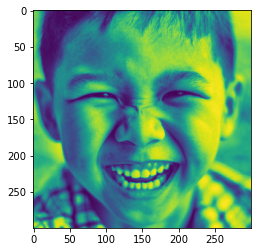

In [5]:
if __name__ == '__main__':
    emotions = ["angry", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]
    model_file = os.path.join('models', 'model1.pkl')
    pkl_file = open(model_file, 'rb')
    data = pickle.load(pkl_file)
    faceDet = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    pkl_file.close()
    Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
    filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
    image = cv2.imread(filename)
    training_data=[]
    #image preprocessing
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray)
    #Cropping the selected image
    face = faceDet.detectMultiScale(clahe_image, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    for (x, y, w, h) in face:
        clahe_image = clahe_image[y:y+h, x:x+w]

    out = cv2.resize(clahe_image, (350, 350))
    landmarks_vectorised = get_landmarks(out)
    # Predict emotion
    training_data.append(landmarks_vectorised)
    npar_pd = np.array(training_data)
    prediction_emo = data.predict(npar_pd)
    
    print(prediction_emo)
    
    plt.imshow(clahe_image)
    
    